# Start of Research on Project

In [1]:
''' use base kernel '''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image, ImageOps

import time

from pathlib import Path

from io import BytesIO
import math

In [2]:
import cv2 as cv

In [3]:
import torch
import torchvision 

In [65]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS ########################
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

/tmp/ipykernel_1953/3660334614.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [5]:
df = pd.read_csv("mot_labels.csv")

df.head()

/tmp/ipykernel_1953/396045525.py:1: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("mot_labels.csv")


name          videoName  frameIndex       id  \
0  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89537.0   
1  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89538.0   
2  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89539.0   
3  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89540.0   
4  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89541.0   

     category attributes.crowd attributes.occluded attributes.truncated  \
0         car            False                True                False   
1         car            False                True                False   
2  pedestrian            False                True                False   
3         car            False               False                False   
4         car            False               False                False   

     box2d.x1     box2d.x2    box2d.y1    box2d.y2  haveVideo  
0  825.173210  1003.094688  355.011547  418.198614       True  
1  484.295612   700.461894  346.697460  424.849885       True  
2  645.588915   663.879908  338.383372  358.337182       True  
3  120.969977   192.471132  359.168591  409.053118       True  
4  251.501155   315.519630  354.180139  400.739030       True

In [5]:
df.columns

Index(['name', 'videoName', 'frameIndex', 'id', 'category', 'attributes.crowd',
       'attributes.occluded', 'attributes.truncated', 'box2d.x1', 'box2d.x2',
       'box2d.y1', 'box2d.y2', 'haveVideo'],
      dtype='object')

* sampling one video as an example:

In [6]:
''' sampling one video from the dataframe 
--> results in all frames & all objects in every frame of the video
--> every row corresponds to a particular frame of the video for a particular object in that frame

COLUMNS:
    - occluded --> obstructed view (not seeing entire edges of the object)

    - name --> jpg name = videName-0000002.jpg for the 2nd frame
    
    - haveVideo --> equals False if we don't have access to its video

961 videos that we have correspond to videos in the dataframe 
(have to ignore 39 of our videos & hundreds of images in the dataframe)
--> dropping anything with column haveVideo equaling False


'''

print("Number of rows for this video: ", len(df[df['videoName'] == "00a0f008-3c67908e"]))

df[df['videoName'] == "00a0f008-3c67908e"].head()



Number of rows for this video:  1502


name          videoName  frameIndex  \
2008673  00a0f008-3c67908e-0000001.jpg  00a0f008-3c67908e           0   
2008674  00a0f008-3c67908e-0000001.jpg  00a0f008-3c67908e           0   
2008675  00a0f008-3c67908e-0000001.jpg  00a0f008-3c67908e           0   
2008676  00a0f008-3c67908e-0000001.jpg  00a0f008-3c67908e           0   
2008677  00a0f008-3c67908e-0000001.jpg  00a0f008-3c67908e           0   

              id category attributes.crowd attributes.occluded  \
2008673  83785.0      car            False               False   
2008674  83786.0      car            False               False   
2008675  83787.0      car            False                True   
2008676  83788.0      car            False                True   
2008677  83789.0      car            False               False   

        attributes.truncated     box2d.x1     box2d.x2    box2d.y1  \
2008673                False   447.984177   488.102283  258.726422   
2008674                False   250.652554   431.639498  230.177599   
2008675                 True  1122.935780  1279.580603  363.774574   
2008676                False  1062.542595  1162.568807  261.861075   
2008677                False   495.388268   531.806000  252.032128   

           box2d.y2  haveVideo  
2008673  289.031524       True  
2008674  360.172190       True  
2008675  584.587156       True  
2008676  329.803408       True  
2008677  287.378750       True

# Showing 1 frame of 1 video

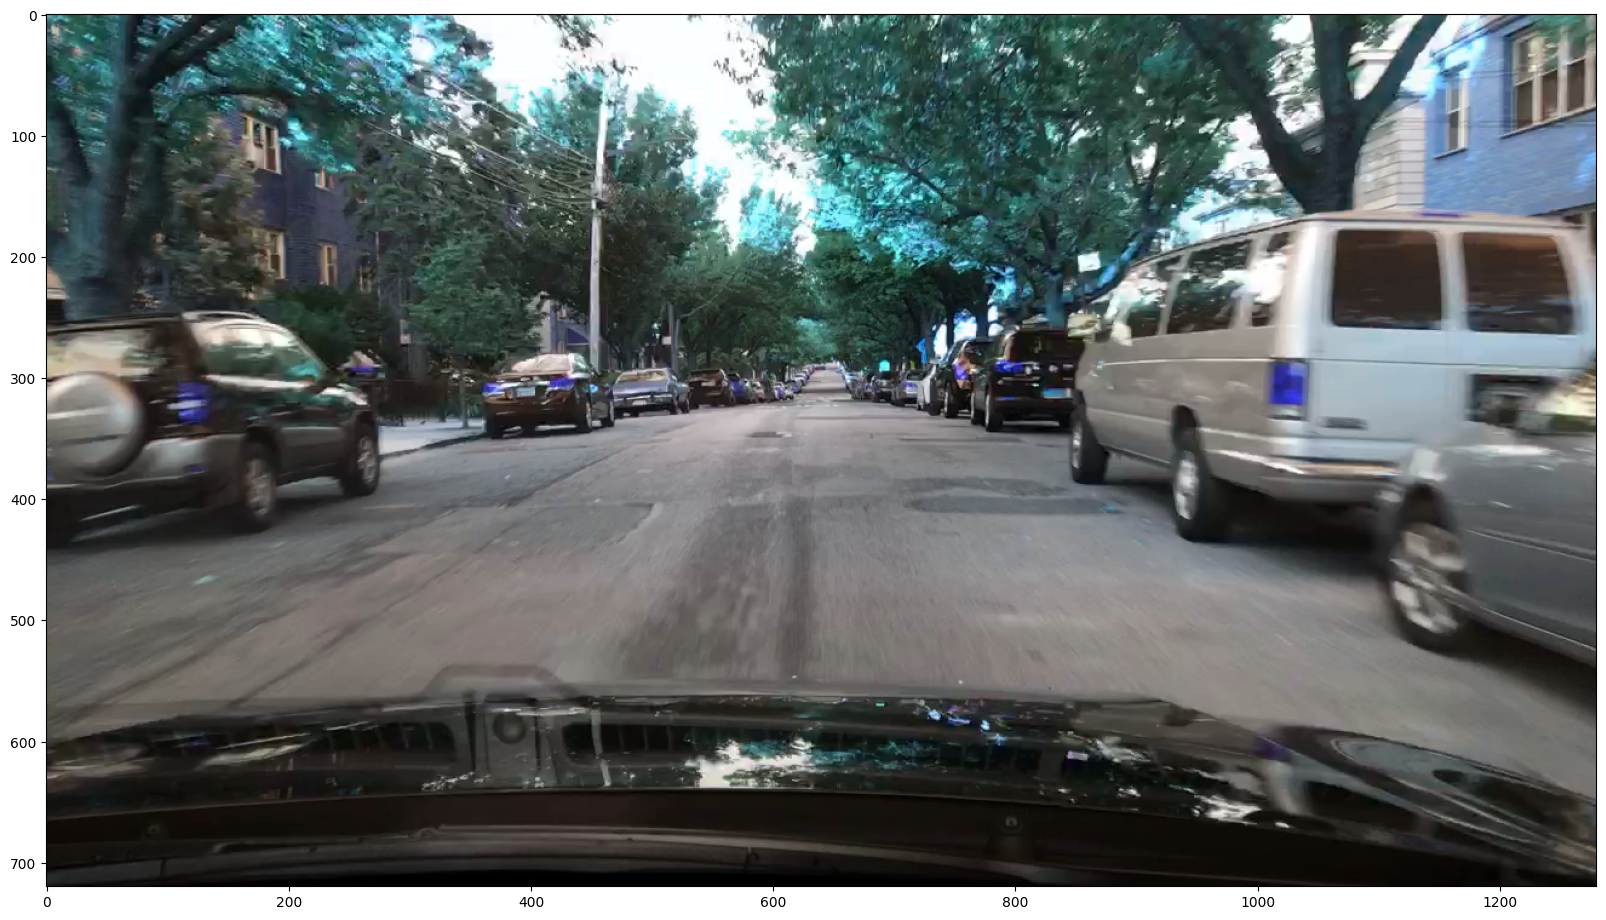

In [7]:
capture = cv.VideoCapture('bdd100k_videos_train_00/bdd100k/videos/train/010fc651-7cf4bc7d.mov')
ret, img = capture.read()
ret, img.shape

plt.figure(figsize = (20,20))
plt.imshow(img)

In [8]:
# checking all the frames for this video

df[df['videoName'] == "010fc651-7cf4bc7d"]['frameIndex'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

# Saving all frames for all videos into the "frames_v2" folder

In [6]:
# saves all video files we have
movie_files = os.listdir('bdd100k_videos_train_00/bdd100k/videos/train')
# saves all unique video names for videos in the dataframe
movies_in_df = list(df['videoName'].unique())
# removes ".mov" from the end of video names & saves these modified video names
movie_files_cleaned = [s[:-4] for s in movie_files]

* filtering data frame to only include videos that we actually have

In [10]:
df[df['haveVideo'] == True].head()

name          videoName  frameIndex       id  \
0  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89537.0   
1  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89538.0   
2  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89539.0   
3  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89540.0   
4  01c71072-718028b8-0000001.jpg  01c71072-718028b8           0  89541.0   

     category attributes.crowd attributes.occluded attributes.truncated  \
0         car            False                True                False   
1         car            False                True                False   
2  pedestrian            False                True                False   
3         car            False               False                False   
4         car            False               False                False   

     box2d.x1     box2d.x2    box2d.y1    box2d.y2  haveVideo  
0  825.173210  1003.094688  355.011547  418.198614       True  
1  484.295612   700.461894  346.697460  424.849885       True  
2  645.588915   663.879908  338.383372  358.337182       True  
3  120.969977   192.471132  359.168591  409.053118       True  
4  251.501155   315.519630  354.180139  400.739030       True

In [11]:
print("Fraction of Dataframe rows (frames & objects for videos) that are for videos we actually have:")
print(len(df[df['haveVideo'] == True]) / len(df))
print(f"{len(df[df['haveVideo'] == True])}/{len(df)}")

Fraction of Dataframe rows (frames & objects for videos) that are for videos we actually have:
0.6650361174548903
1922517/2890846


In [12]:
print("Fraction of Dataframe videos that are videos we actually have")
print(df[df['haveVideo'] == True]['videoName'].nunique() / df['videoName'].nunique())
print(f"{df[df['haveVideo'] == True]['videoName'].nunique()}/{df['videoName'].nunique()}")

Fraction of Dataframe videos that are videos we actually have
0.6864285714285714


961/1400


In [13]:
print("Fraction of videos we have that are in teh dataframe")
print(df[df['haveVideo'] == True]['videoName'].nunique() / len(movie_files_cleaned))
print(f"{df[df['haveVideo'] == True]['videoName'].nunique()}/{len(movie_files_cleaned)}")

Fraction of videos we have that are in teh dataframe
0.961
961/1000


* saving a cleaned version of the dataframe only containing the data for videos we actually have and are in teh dataframe as well

In [14]:
df_cleaned = df[df['haveVideo'] == True]
df_cleaned['videoName'].nunique()

961

* saving the cleaned dataframe to CSV (commented out; already done)

In [15]:
df_cleaned.to_csv("df_cleaned.csv", index=False)

* determine the maximum number of frames found in any video of the videos we have

    * (already done - if commented out)

In [16]:
# * determine the maximum number of frames found in any video of the videos we have

max_numFrames = 0

numMovies = len(movies_in_df)

for i, name in enumerate(movies_in_df):
    print(f"{i+1} / {numMovies}")
    # if the video in the dataframe is not in the the videos we have, skip it
    if name not in movie_files_cleaned:
        continue
    # OTHERWISE, count how many frames it has in the dataframe
    numFrames = df[df['videoName'] == name]['frameIndex'].nunique()
    max_numFrames = max(numFrames, max_numFrames)

# printing below the maximum number of frames found in all videos
print(max_numFrames)



# saving all frames of every video was already done (commented out when already done)

## "frame index" in dataframe did not correspond to the frame number of the video 

* was only every 6th frame of the video 

    * videos were decreased from 30 Hz to 5 Hz 

In [17]:
'''
save each frame of every video into the folder "frames_v2"
'''

# to keep count of progress of saving frames for all videos into the folder "frames"
numMovies = len(movie_files_cleaned)


# iterate through every video we have saved
for i, m in enumerate(movie_files_cleaned):
    print(f"{i+1} / {numMovies}")
    # if this video is in the dataframe
    if m in movies_in_df:
        # load in the video
        capture = cv.VideoCapture(f'bdd100k_videos_train_00/bdd100k/videos/train/{m}.mov')
        # count number of frames of the video 
        n_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT)) 
        for frame in range(n_frames):
            # capture the frame
            ret, img = capture.read()
            if frame % 6 == 1:
                frameNum = int(frame / 6) + 1
                # convert the array into an image:
                img = Image.fromarray(img)
                # if it has reached ned of video --> break
                if ret == False:
                    break
                # otherwise, add it to the folder of frames
                # Save the image to the folder with a new name (if desired)
                # file path:
                path = 'frames_v2/'
                if frameNum+1 < 10:
                    # output_path = os.path.join(path, f'{m}-000000{frame}.jpg')
                    file_name = f'{m}-000000{frameNum+1}.jpg'
                elif frameNum+1 < 100 and frameNum+1 >= 10:
                    # output_path = os.path.join(path, f'{m}-00000{frame}.jpg')
                    file_name = f'{m}-00000{frameNum+1}.jpg'
                elif frameNum+1 < 1000 and frameNum+1 >= 100:
                    # output_path = os.path.join(path, f'{m}-0000{frame}.jpg')
                    file_name = f'{m}-0000{frameNum+1}.jpg'
                # img.save(output_path)
                img.save(os.path.join(path, file_name))

## checking first 10 frames of a video and checking if the marked box corners for the given video and its corresponding frame number match what is found in the dataframe 

In [8]:
df_cleaned = pd.read_csv('df_cleaned.csv')

In [27]:
video = df_cleaned['videoName'].unique()[10]

frames_vid = df_cleaned[df_cleaned['videoName'] == video]['name'].unique()

frames_vid[0]

'024ac038-ffa0ed50-0000001.jpg'

In [28]:
print(len(frames_vid))

202


In [29]:
all_frames = os.listdir('frames_v2')
f = [s for s in all_frames if '024ac038-ffa0ed50' in s]
print(len(f))

202


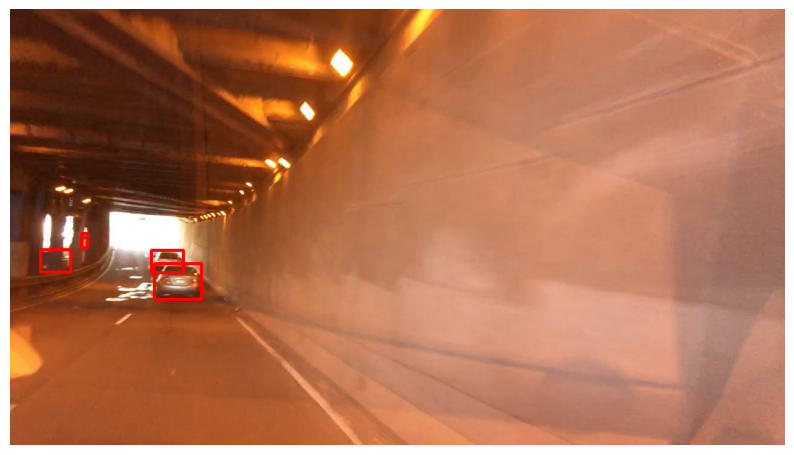

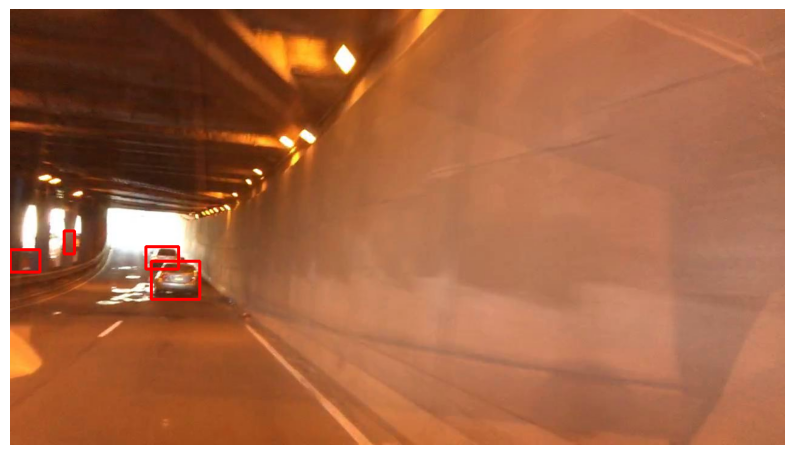

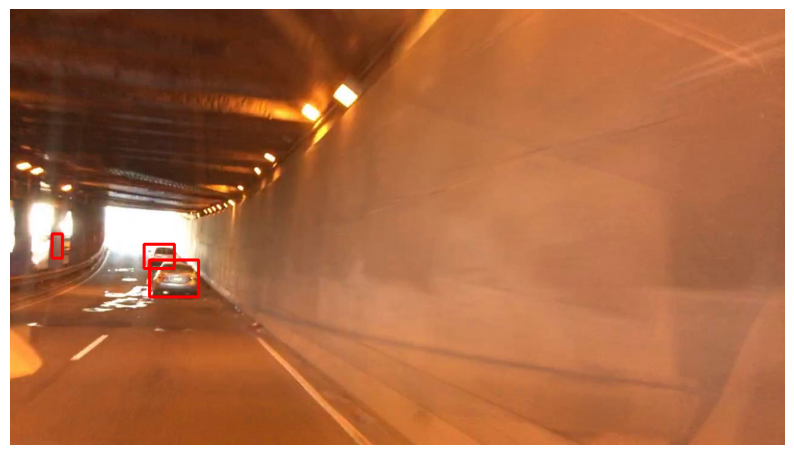

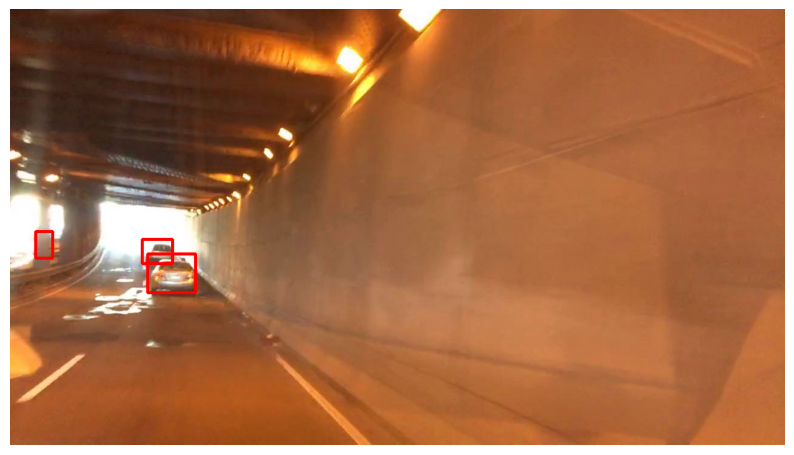

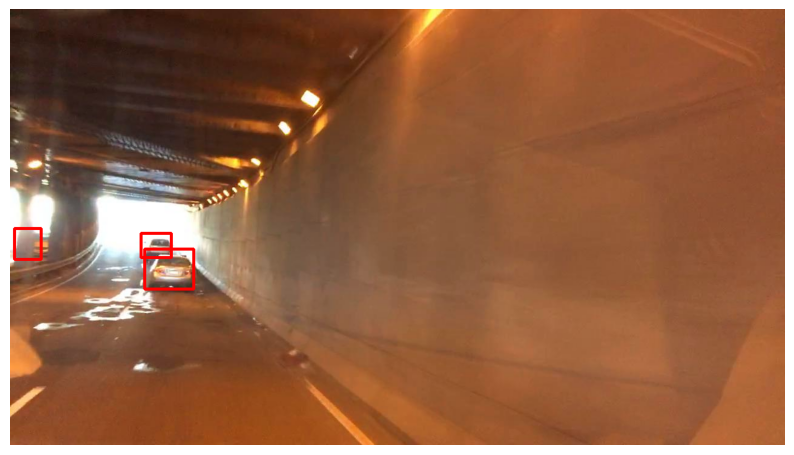

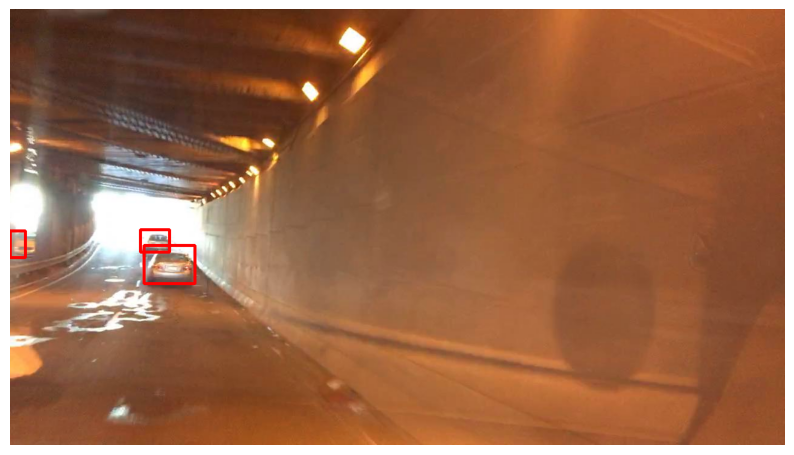

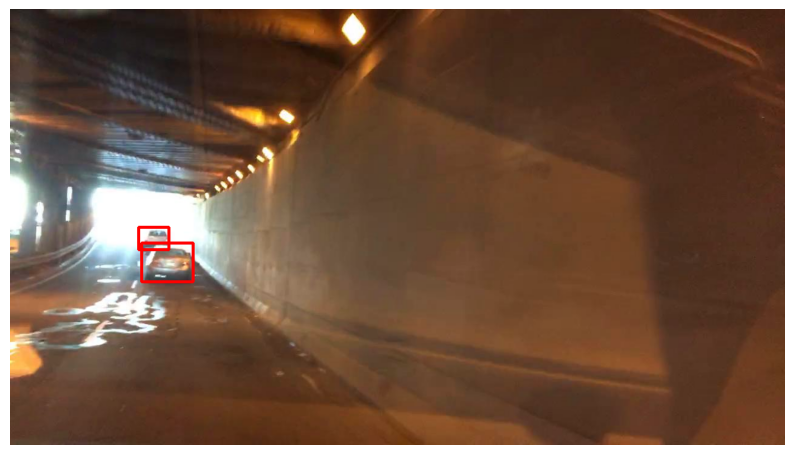

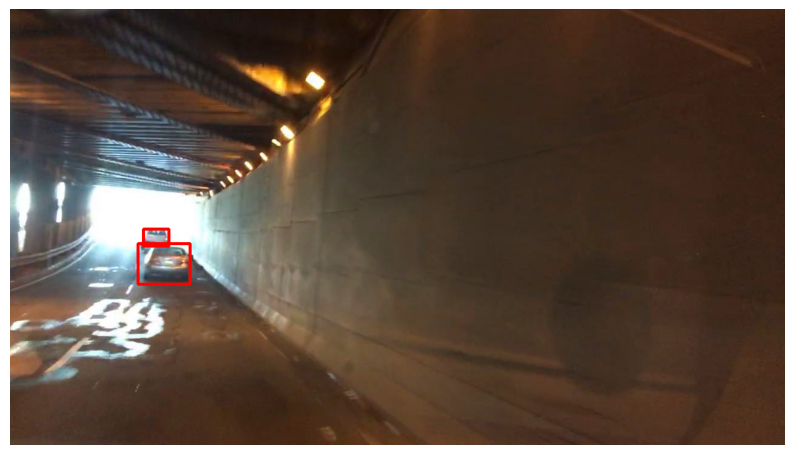

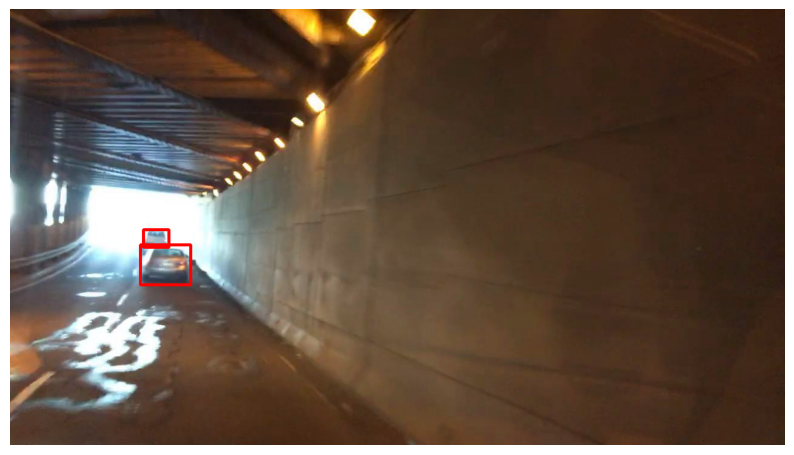

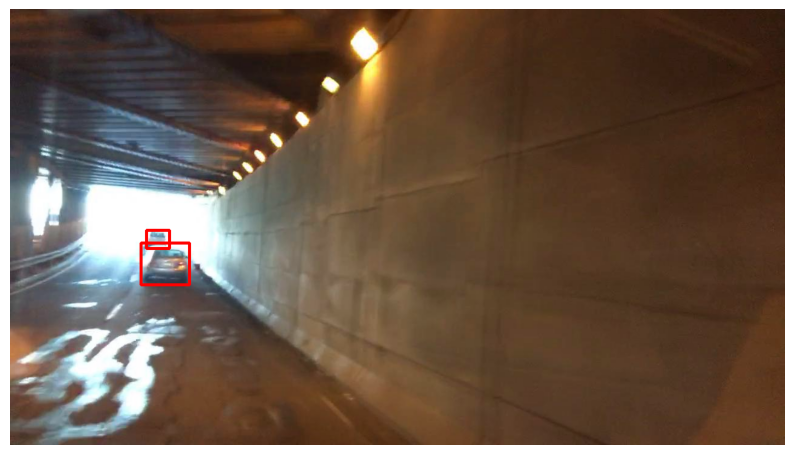

In [30]:
path = 'frames_v2/'

count = 0

for f in frames_vid:

    if count == 10:
        break

    try: 

        img = Image.open(f'frames_v2/{f}')
        img = np.array(img)


        def display_cv2_img(img, figsize=(10, 10)):
            img_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            fig, ax = plt.subplots(figsize=figsize)
            ax.imshow(img_)
            ax.axis("off")
            plt.show()

        color_map = {
            "car": (0, 0, 255),
            "truck": (0, 0, 100),
            "pedestrian": (255, 0, 0),
            "other vehicle": (0, 0, 150),
            "rider": (200, 100, 0),
            "bicycle": (0, 255, 0),
            "other person": (200, 0, 0),
            "trailer": (0, 150, 150),
            "motorcycle": (0, 150, 0),
            "bus": (0, 0, 100),
        }


        img_example = img.copy()
        frame_labels = df_cleaned[df_cleaned['name'] == f]
        for i, d in frame_labels.iterrows():
            pt1 = int(d['box2d.x1']), int(d['box2d.y1'])
            pt2 = int(d['box2d.x2']), int(d['box2d.y2'])
            color = color_map[d['category']]
            cv.rectangle(img_example, pt1, pt2, color, 3)
        display_cv2_img(img_example)

        count +=1 

    except IOError:
        continue

# Multi-Label Stratification

* to ensure even split of data among count of each class label (for when train, validation, and test set splits are done)

In [9]:
class_counts = df_cleaned.groupby(['videoName', 'category']).size().unstack(fill_value=0)
class_counts.reset_index(inplace=True)

In [37]:
!pip install iterative-stratification

In [38]:
# from iterative_stratification after installing it:
# import iterstrat
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# Extract features and labels
X = class_counts['videoName'].values.reshape(-1, 1)  # Features are just the video IDs
y = class_counts.iloc[:, 1:].values  # Labels are the counts of each object class

# Initialize the multi-label stratified shuffle splitter
# Set test_size to the desired proportion, e.g., 0.2 for 20%
msss = MultilabelStratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Perform the split
train_fold_idx_list = []
test_fold_idx_list = []
for train_index, test_index in msss.split(X, y):
    # Split the dataframe into train and test sets based on the indices
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [39]:
X_train_list = [videoName[0] for videoName in X_train]
X_test_list = [videoName[0] for videoName in X_test]
counts_train_df = class_counts[class_counts['videoName'].isin(X_train_list)]
counts_test_df = class_counts[class_counts['videoName'].isin(X_test_list)]
train_counts_df = pd.merge(df, counts_train_df, on='videoName')
test_counts_df = pd.merge(df, counts_test_df, on='videoName')

labels = df['category'].dropna().unique()
train_class_distribution = train_counts_df[labels].sum().sort_index()
test_class_distribution = test_counts_df[labels].sum().sort_index()

print('Train Class Distribution:')
print(train_class_distribution)
print('-' * 30)
print('Test Class Distribution:')
print(test_class_distribution)

Train Class Distribution:
bicycle            43273284
bus                80251378
car              2819014979
motorcycle         14646608
other person        4124026
other vehicle      27579617
pedestrian        617168271
rider              29390972
trailer             1651378
train               2392706
truck             187455268
dtype: int64
------------------------------
Test Class Distribution:
bicycle            8862529
bus               17950431
car              656626838
motorcycle         4782126
other person        706809
other vehicle      6153446
pedestrian       152417293
rider              6216293
trailer             638340
train               517097
truck             46246750
dtype: int64


In [40]:
train_class_distribution = train_counts_df['category'].value_counts(normalize=True)
test_class_distribution = test_counts_df['category'].value_counts(normalize=True)

# Create a DataFrame to compare the distributions
comparison_df = pd.DataFrame({
    'Train Distribution': train_class_distribution,
    'Test Distribution': test_class_distribution
})

print(comparison_df)

               Train Distribution  Test Distribution
category                                            
bicycle                  0.010295           0.008881
bus                      0.019954           0.021410
car                      0.768754           0.762791
motorcycle               0.003867           0.004866
other person             0.000919           0.000612
other vehicle            0.007003           0.006545
pedestrian               0.131266           0.137790
rider                    0.006734           0.007024
trailer                  0.000342           0.000866
train                    0.000557           0.000514
truck                    0.050309           0.048700


In [44]:
train_class_distribution

category
car              0.768754
pedestrian       0.131266
truck            0.050309
bus              0.019954
bicycle          0.010295
other vehicle    0.007003
rider            0.006734
motorcycle       0.003867
other person     0.000919
train            0.000557
trailer          0.000342
Name: proportion, dtype: float64

In [47]:
len(X_train) / (len(X_train) + len(X_test))

0.7991675338189386

In [48]:
len(X_test) / (len(X_train) + len(X_test))

0.2008324661810614

In [54]:
# save X_train & X_test:

''' 
ALREADY SAVED 
--> load them below
'''

train_videos = pd.read_csv('train_videos.csv',header=None, index_col=0)
test_videos = pd.read_csv('test_videos.csv',header=None, index_col=0)



In [72]:
# adjustments to dataframe for DETR:
# make adjustments to df_cleaned to include new columns for the DETR model:

df_cleaned['x'] = df_cleaned['box2d.x1']
df_cleaned['y'] = df_cleaned['box2d.y1']
df_cleaned['w'] = df_cleaned['box2d.x2'] - df_cleaned['box2d.x1']
df_cleaned['h'] = df_cleaned['box2d.y2'] - df_cleaned['box2d.y1']
df_cleaned.head()



In [85]:
#filtering to only include frames of videos that we have images for:
jpegs = os.listdir('frames_v2')
df_cleaned = df_cleaned[df_cleaned['name'].isin(jpegs)].copy()


# save the updated dataframe as a csv:
df_cleaned.to_csv('df_cleaned.csv', index=False)

In [87]:
# save dataframes for training set & testing set

train_df = df_cleaned[df_cleaned['videoName'].isin(X_train_list)]
test_df = df_cleaned[df_cleaned['videoName'].isin(X_test_list)]

print(len(train_df) / (len(train_df) +len(test_df) ))
print(len(test_df) / (len(train_df) +len(test_df) ))

0.7841060746416291
0.21589392535837088
